# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import os
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.metrics import structural_similarity as ssim

In [ ]:
# !unzip smileys.zip

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Generator Class

In [ ]:
# class Generator(nn.Module):
#     def __init__(self, noise_dim=100, channels=3):
#         super(Generator, self).__init__()
#         self.noise_dim = noise_dim
#         self.channels = channels
#         generator_channels = 256

#         self.main = nn.Sequential(
#             nn.ConvTranspose2d(self.noise_dim, generator_channels * 8, 4, 1, 0, bias=False),
#             nn.BatchNorm2d(generator_channels * 8),
#             nn.ReLU(True),

#             nn.ConvTranspose2d(generator_channels * 8, generator_channels * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(generator_channels * 4),
#             nn.ReLU(True),

#             nn.ConvTranspose2d(generator_channels * 4, generator_channels * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(generator_channels * 2),
#             nn.ReLU(True),

#             nn.ConvTranspose2d(generator_channels * 2, generator_channels, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(generator_channels),
#             nn.ReLU(True),

#             nn.ConvTranspose2d(generator_channels, self.channels, 4, 2, 1, bias=False),
#             nn.Tanh()
#         )

#     def forward(self, input):
#         return self.main(input)


class Generator(nn.Module):
    def __init__(self, noise_dim=100, channels=3, generator_channels=512):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.channels = channels

        self.main = nn.Sequential(
            nn.ConvTranspose2d(self.noise_dim, generator_channels * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(generator_channels * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(generator_channels * 8, generator_channels * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_channels * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(generator_channels * 4, generator_channels * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_channels * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(generator_channels * 2, generator_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_channels),
            nn.ReLU(True),

            nn.ConvTranspose2d(generator_channels, self.channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Discriminator

In [ ]:

class Discriminator(nn.Module):
    def __init__(self, channels=3, d_channels=32):
        super(Discriminator, self).__init__()
        self.channels = channels

        self.main = nn.Sequential(
            nn.Conv2d(self.channels, d_channels, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(d_channels, d_channels * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(d_channels * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(d_channels * 2, d_channels * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(d_channels * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(d_channels * 4, d_channels * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(d_channels * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(d_channels * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Training Loop

In [ ]:
def calculate_ssim_loss(generated_images, real_images, device=None):
    gen = generated_images.detach().cpu().numpy()
    real = real_images.detach().cpu().numpy()
    svals = []
    n = min(len(gen), len(real))
    for i in range(n):
        g = np.clip((gen[i].transpose(1, 2, 0) + 1) / 2.0, 0, 1)
        r = np.clip((real[i].transpose(1, 2, 0) + 1) / 2.0, 0, 1)
        try:
            svals.append(ssim(g, r, data_range=1.0, channel_axis=2))
        except Exception:
            svals.append(0.0)
    avg = float(np.mean(svals)) if svals else 0.0
    return 1.0 - avg, avg

def calculate_epoch_ssim(generator, dataloader, device, num_samples=100, z_dim=100):
    generator.eval()
    svals = []
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            if i * dataloader.batch_size >= num_samples:
                break
            real = data[0].to(device)
            b = real.size(0)
            noise = torch.randn(b, z_dim, 1, 1, device=device)
            fake = generator(noise)
            _, batch_avg = calculate_ssim_loss(fake, real, device)
            svals.append(batch_avg)
    generator.train()
    return float(np.mean(svals)) if svals else 0.0

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

dataroot = Path("/kaggle/input/uploads/smileys/smileys")
workers = 2
batch_size = 16
image_size = 64
noise_dim = 100
generator_channels = 512
d_channels = 32
num_epochs = 200
lr = 0.00015
beta1 = 0.4

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = ImageFolder(root=dataroot,
                      transform=transform)
dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=workers)

print(f"Dataset size: {len(dataset)} images")
print(f"Number of batches per epoch: {len(dataloader)}")
print(f"Training parameters: nc=3, noise_dim={noise_dim}, generator_channels={generator_channels}, d_channels={d_channels}")

generator = Generator(noise_dim, 3, generator_channels).to(device)
generator.apply(weights_init)

discriminator = Discriminator(3, d_channels).to(device)
discriminator.apply(weights_init)

criterion = nn.BCELoss()

fixed_noise = torch.randn(64, noise_dim, 1, 1, device=device)
real_label = 1
fake_label = 0

optimizerD = optim.Adam(discriminator.parameters(), lr=lr * 0.5, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

G_losses = []
D_losses = []
ssim_losses = []
ssim_values = []

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        discriminator.zero_grad()
        real = data[0].to(device)
        b_size = real.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        output = discriminator(real).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()

        noise = torch.randn(b_size, noise_dim, 1, 1, device=device)
        fake = generator(noise)
        label.fill_(fake_label)
        output = discriminator(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        errD = errD_real + errD_fake

        if errD.item() > 0.1:
            optimizerD.step()

        generator.zero_grad()
        label.fill_(real_label)
        output = discriminator(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

        G_losses.append(errG.item())
        D_losses.append(errD.item())

    print(f'{epoch + 1}/{num_epochs}   Loss_D: {errD.item():.4f}   Loss_G: {errG.item():.4f}')

    epoch_ssim = calculate_epoch_ssim(generator, dataloader, device, num_samples=100)
    ssim_loss = 1.0 - epoch_ssim

    ssim_losses.append(ssim_loss)
    ssim_values.append(epoch_ssim)


    if epoch % 100 == 0:
        torch.save(generator.state_dict(), f'generator_epoch{epoch}.pth')
        torch.save(discriminator.state_dict(), f'discriminator_epoch{epoch}.pth')

torch.save(generator.state_dict(), 'generator_final.pth')
torch.save(discriminator.state_dict(), 'discriminator_final.pth')

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('training_loss.png')
plt.close()

Using device: cuda
Dataset size: 108 images
Number of batches per epoch: 7
Training parameters: nc=3, noise_dim=100, generator_channels=512, d_channels=32
Starting Training Loop...
1/200   Loss_D: 5.8346   Loss_G: 0.0325
2/200   Loss_D: 4.6996   Loss_G: 0.2809
3/200   Loss_D: 4.7586   Loss_G: 0.2938
4/200   Loss_D: 4.8429   Loss_G: 0.3018
5/200   Loss_D: 4.5319   Loss_G: 0.5346
6/200   Loss_D: 1.5034   Loss_G: 2.3767
7/200   Loss_D: 1.9915   Loss_G: 2.2093
8/200   Loss_D: 1.8218   Loss_G: 2.1107
9/200   Loss_D: 1.0277   Loss_G: 2.5873
10/200   Loss_D: 1.4186   Loss_G: 2.3559
11/200   Loss_D: 1.1888   Loss_G: 2.7524
12/200   Loss_D: 1.1252   Loss_G: 2.6144
13/200   Loss_D: 0.7632   Loss_G: 2.8842
14/200   Loss_D: 1.2471   Loss_G: 2.7306
15/200   Loss_D: 0.5820   Loss_G: 2.6765
16/200   Loss_D: 0.7444   Loss_G: 2.6191
17/200   Loss_D: 0.7281   Loss_G: 2.6795
18/200   Loss_D: 0.8547   Loss_G: 2.6773
19/200   Loss_D: 0.9616   Loss_G: 2.6668
20/200   Loss_D: 0.6590   Loss_G: 2.9738
21/200  

# Training Loss and SSIM

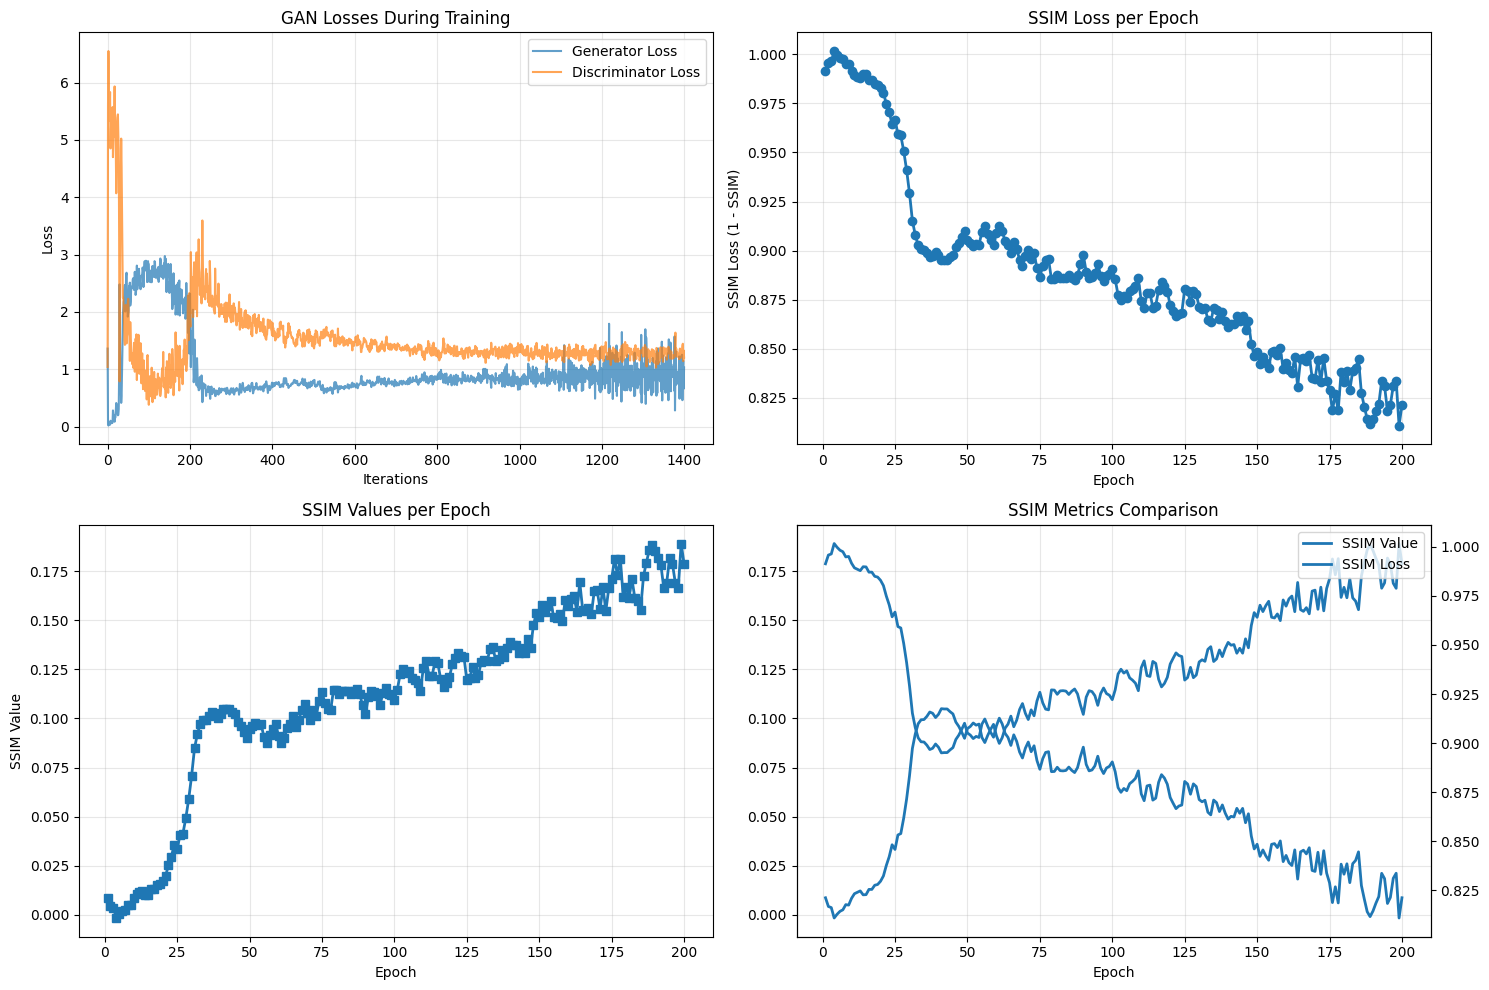

In [ ]:

epochs = np.arange(1, len(ssim_losses) + 1)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(G_losses, label='Generator Loss', alpha=0.7)
axes[0, 0].plot(D_losses, label='Discriminator Loss', alpha=0.7)
axes[0, 0].set(title='GAN Losses During Training', xlabel='Iterations', ylabel='Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(epochs, ssim_losses, linewidth=2, marker='o')
axes[0, 1].set(title='SSIM Loss per Epoch', xlabel='Epoch', ylabel='SSIM Loss (1 - SSIM)')
axes[0, 1].grid(alpha=0.3)

axes[1, 0].plot(epochs, ssim_values, linewidth=2, marker='s')
axes[1, 0].set(title='SSIM Values per Epoch', xlabel='Epoch', ylabel='SSIM Value')
axes[1, 0].grid(alpha=0.3)

ax_main = axes[1, 1]
ax2 = ax_main.twinx()
l1, = ax_main.plot(epochs, ssim_values, linewidth=2, label='SSIM Value')
l2, = ax2.plot(epochs, ssim_losses, linewidth=2, label='SSIM Loss')
ax_main.set(xlabel='Epoch', title='SSIM Metrics Comparison')
ax_main.grid(alpha=0.3)
ax_main.legend([l1, l2], [l1.get_label(), l2.get_label()], loc='upper right')

plt.tight_layout()
plt.savefig('training_metrics_with_ssim.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# !rm generator_epo*

In [ ]:
# !rm discriminator_epo*

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

In [ ]:
# generator = Generator().to(device)
# generator.load_state_dict(torch.load('/kaggle/working/generator_final.pth'))
# generator.eval()

In [ ]:
# noise = torch.randn(1, 100, 1, 1, device=device)

# fake = generator(noise)


## Random Generations

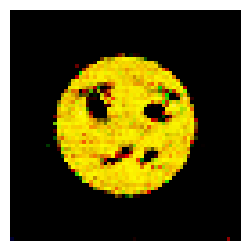

In [ ]:
noise = torch.randn(1, 100, 1, 1, device=device)

fake = generator(noise)

plt.figure(figsize=(3,3))
plt.imshow(fake.detach().cpu()[0].permute(1,2,0).numpy())
plt.axis('off')
plt.show()